In [1]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np

import copy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/train"
val_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/test"
test_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/test"

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print the number of images in each dataset
print("Number of images in train dataset:", len(train_dataset))
print("Number of images in validation dataset:", len(val_dataset))
print("Number of images in test dataset:", len(test_dataset))


Number of images in train dataset: 2000
Number of images in validation dataset: 600
Number of images in test dataset: 600


In [5]:
num_classes = len(train_dataset.classes)

In [6]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=9610c96274db0c1ba31aa1ebb7d3e16f05996e96054cf08c369aa1aa568026f1
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
Note: you may need to restart the kernel to use updated packages.


In [7]:
import torch.nn as nn
from torchvision.models import squeezenet1_1

class SqueezeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SqueezeNetClassifier, self).__init__()
        # Load the pretrained SqueezeNet1.1 model.
        self.model = squeezenet1_1(pretrained=True)
        # Replace the final convolutional layer in the classifier.
        # The original classifier is a Sequential of: Dropout, Conv2d, ReLU, AdaptiveAvgPool2d.
        # Here we replace the Conv2d layer (index 1) with one that outputs 'num_classes' channels.
        self.model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        self.num_classes = num_classes

    def forward(self, x):
        x = self.model(x)  # Expected output shape: (batch, num_classes, 1, 1)
        # Flatten the output to shape (batch, num_classes)
        return x.view(x.size(0), self.num_classes)

In [8]:
def calculate_metrics(labels, preds):
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return precision, recall, f1

In [9]:
def calculate_specificity_sensitivity(labels, preds):
    """Calculate sensitivity and specificity."""
    cfm = confusion_matrix(labels, preds)
    TP = cfm[1, 1]
    TN = cfm[0, 0]
    FP = cfm[0, 1]
    FN = cfm[1, 0]

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Avoid division by zero
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Avoid division by zero

    return sensitivity, specificity

In [10]:
import matplotlib.pyplot as plt

def plot_metrics(train_values, val_values, title, ylabel):
    plt.figure(figsize=(6, 4))  # Set the figure size
    plt.style.use('seaborn')  # Set the plot style
    plt.title(title, fontsize=16, fontweight='bold')  # Set the title
    plt.plot(train_values, label='Training', color='blue', linewidth=2)  # Plot training values
    plt.plot(val_values, label='Validation', color='orange', linewidth=2)  # Plot validation values
    plt.xlabel('Epochs', fontsize=14)  # Set the x-label
    plt.ylabel(ylabel, fontsize=14)  # Set the y-label
    plt.legend(fontsize=12)  # Add legend
    plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines
    plt.show()  # Show the plot

In [11]:
def extract_features_and_labels(model, data_loader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, batch_labels in tqdm(data_loader, desc="Extracting Features"):
            images = images.to(device)
            batch_labels = batch_labels.to(device)
            images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            if isinstance(model, nn.DataParallel):
                output_features = model.module.get_features(images)
            else:
                output_features = model.get_features(images)
            features.extend(output_features.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return {'features': np.array(features), 'labels': np.array(labels)}

In [12]:
class CustomLoss(nn.Module):
    def __init__(self, num_classes):
        super(CustomLoss, self).__init__()
        self.num_classes = num_classes
        self.initial_alpha = 0.6
        self.initial_gamma = 3
        self.initial_ce_weight = 0.2
        self.initial_focal_weight = 0.9
        self.initial_smoothing = 0.1

    def forward(self, output, target, current_epoch, total_epochs):
        # Dynamic adjustments based on the epoch number
        decay_factor = current_epoch / total_epochs
        alpha = self.initial_alpha * (1 - decay_factor)  # Decrease alpha over time
        gamma = self.initial_gamma * (1 - decay_factor)  # Decrease gamma over time
        ce_weight = self.initial_ce_weight  # Could also be adjusted dynamically
        focal_weight = self.initial_focal_weight * (1 - decay_factor)  # Decrease focal weight
        smoothing = self.initial_smoothing * (1 - decay_factor)  # Decrease smoothing

        # Adjust class weights based on the frequency of each class
        class_counts = torch.zeros(self.num_classes, device=output.device)
        for c in range(self.num_classes):
            class_counts[c] = (target == c).sum()

        epsilon = 1e-6
        class_weights = 1.0 / (class_counts + epsilon)
        class_weights = class_weights / class_weights.sum()  # normalize to sum to 1

        # Compute log probabilities
        log_probs = F.log_softmax(output, dim=1)

        # Apply label smoothing
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(smoothing / (self.num_classes - 1))
        true_dist.scatter_(1, target.unsqueeze(1), 1 - smoothing)

        # Compute the cross-entropy loss with label smoothing
        ce_loss = torch.mean(torch.sum(-true_dist * log_probs, dim=1))

        # Compute the focal component
        pt = torch.exp(-ce_loss)
        focal_loss = alpha * (1 - pt) ** gamma * ce_loss

        # Combine the losses with respective weights
        total_loss = ce_weight * ce_loss + focal_weight * focal_loss

        return total_loss

In [13]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=d21bfc189a23bf2280e53713dadb90f541022a4c5fc16c2d5aacd50e688817dc
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=d673b02a8f395c3fb8b7dfa4886efe0368ad4f9f2c0f2618c7cac8a8d4005001
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from fvcore.nn import FlopCountAnalysis, parameter_count_table
import time
import copy

# Define snapshot ensemble function
def snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device):

    ensemble_models = []
    snapshot_epochs = [30, 70, 120]
    best_snapshot_weights = None

    model = SqueezeNetClassifier(num_classes).to(device)
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    # FLOPs and parameter count
    sample_input = torch.randn(1, 3, 224, 224).to(device)
    flops = FlopCountAnalysis(model, sample_input)
    print("Model FLOPs and Parameter Count:")
    print(parameter_count_table(model))
    print(f"Total FLOPs: {flops.total() / 1e9:.2f} GFLOPs")

    criterion = CustomLoss(num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = CosineAnnealingLR(optimizer, T_max=snapshot_epochs[0], eta_min=1e-8)

    train_accs, val_accs, train_losses, val_losses, test_accs, test_losses = [], [], [], [], [], []
    learning_rates = []

    total_epochs = 120
    best_val_accuracy = 0

    for epoch in range(total_epochs):
        if epoch in snapshot_epochs and epoch != snapshot_epochs[-1]:
            optimizer = optim.Adam(model.parameters(), lr=0.0001)
            next_snapshot_index = snapshot_epochs.index(epoch) + 1
            epochs_until_next_snapshot = snapshot_epochs[next_snapshot_index] - epoch
            scheduler = CosineAnnealingLR(optimizer, T_max=epochs_until_next_snapshot, eta_min=1e-8)

        lr_rate = optimizer.param_groups[0]['lr']
        learning_rates.append(lr_rate)
        print(f"Epoch {epoch + 1}/{total_epochs}, Learning Rate: {lr_rate}")

        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_preds = []
        train_labels = []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels, epoch, total_epochs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_accuracy = train_correct / train_total
        train_accs.append(train_accuracy)
        train_losses.append(train_loss / train_total)

        train_precision = precision_score(train_labels, train_preds, average='weighted')
        train_recall = recall_score(train_labels, train_preds, average='weighted')
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        print(f"Train Loss: {train_loss / train_total:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")

        # Validation phase
        model.eval()
        torch.cuda.reset_peak_memory_stats(device)
        start_time = time.time()

        val_loss = 0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels, epoch, total_epochs)
                val_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        end_time = time.time()
        inference_time = end_time - start_time
        memory_used = torch.cuda.max_memory_allocated(device) / (1024 ** 2)

        print(f"Validation Inference Time: {inference_time:.2f} sec, Peak GPU Memory: {memory_used:.2f} MB")

        val_accuracy = val_correct / val_total
        val_accs.append(val_accuracy)
        val_losses.append(val_loss / val_total)

        val_precision = precision_score(val_labels, val_preds, average='weighted')
        val_recall = recall_score(val_labels, val_preds, average='weighted')
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        print(f"Validation Loss: {val_loss / val_total:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_snapshot_weights = copy.deepcopy(model.state_dict())
            print("Best model updated based on validation accuracy")

        if epoch + 1 in snapshot_epochs:
            snapshot_count = snapshot_epochs.index(epoch + 1)
            ensemble_models.append(copy.deepcopy(model))
            torch.save(model.state_dict(), f'snapshot_{snapshot_count}_model.pth')
            print(f"Snapshot {snapshot_count} saved")

            model.load_state_dict(best_snapshot_weights)
            test_loss = 0
            test_correct = 0
            test_total = 0
            test_preds = []
            test_labels = []

            start_time = time.time()
            with torch.no_grad():
                for images, labels in tqdm(test_loader, desc="Testing"):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels, epoch, total_epochs)
                    test_loss += loss.item() * labels.size(0)
                    _, predicted = torch.max(outputs, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()
                    test_preds.extend(predicted.cpu().numpy())
                    test_labels.extend(labels.cpu().numpy())
            end_time = time.time()

            inference_time = end_time - start_time
            memory_used = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
            print(f"Test Inference Time: {inference_time:.2f} sec, Peak GPU Memory: {memory_used:.2f} MB")

            test_accuracy = test_correct / test_total
            test_accs.append(test_accuracy)
            test_losses.append(test_loss / test_total)

            test_precision = precision_score(test_labels, test_preds, average='weighted')
            test_recall = recall_score(test_labels, test_preds, average='weighted')
            test_f1 = f1_score(test_labels, test_preds, average='weighted')
            print(f"Test Loss: {test_loss / test_total:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

            print("Classification Report for Test Data:")
            print(classification_report(test_labels, test_preds))

            conf_matrix = confusion_matrix(test_labels, test_preds)
            conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

            plt.figure(figsize=(6, 4))
            sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

            sensitivity, specificity = calculate_specificity_sensitivity(test_labels, test_preds)
            print(f"Test Sensitivity: {sensitivity:.4f}, Test Specificity: {specificity:.4f}")

            plot_metrics(train_accs, val_accs, 'Accuracy vs. Epochs', 'Accuracy')
            plot_metrics(train_losses, val_losses, 'Loss vs. Epochs', 'Loss')

            plt.figure(figsize=(6, 4))
            plt.plot(range(1, epoch + 2), learning_rates)
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.title('Learning Rate vs. Epochs')
            plt.grid(True)
            plt.show()

        scheduler.step()

    return ensemble_models


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 45.2MB/s]


Using 2 GPUs!
Model FLOPs and Parameter Count:
| name                       | #elements or shape   |
|:---------------------------|:---------------------|
| model                      | 0.7M                 |
|  module                    |  0.7M                |
|   module.model             |   0.7M               |
|    module.model.features   |    0.7M              |
|    module.model.classifier |    1.5K              |
Total FLOPs: 0.26 GFLOPs
Epoch 1/120, Learning Rate: 0.0001


Epoch 1/120: 100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


Train Loss: 0.2962, Accuracy: 0.6590, Precision: 0.5380, Recall: 0.6590, F1 Score: 0.5647


Validation: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 6.51 sec, Peak GPU Memory: 420.69 MB
Validation Loss: 0.3265, Accuracy: 0.6533, Precision: 0.5091, Recall: 0.6533, F1 Score: 0.5375
Best model updated based on validation accuracy
Epoch 2/120, Learning Rate: 9.972612215893683e-05


Epoch 2/120: 100%|██████████| 16/16 [00:07<00:00,  2.05it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2558, Accuracy: 0.6870, Precision: 0.5682, Recall: 0.6870, F1 Score: 0.6012


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 2.11 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.3132, Accuracy: 0.6267, Precision: 0.5066, Recall: 0.6267, F1 Score: 0.5548
Epoch 3/120, Learning Rate: 9.890748929868662e-05


Epoch 3/120: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


Train Loss: 0.2389, Accuracy: 0.7040, Precision: 0.5947, Recall: 0.7040, F1 Score: 0.6161


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Validation Inference Time: 2.19 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2930, Accuracy: 0.6483, Precision: 0.5862, Recall: 0.6483, F1 Score: 0.5686
Epoch 4/120, Learning Rate: 9.755307053217622e-05


Epoch 4/120: 100%|██████████| 16/16 [00:07<00:00,  2.00it/s]


Train Loss: 0.2275, Accuracy: 0.7110, Precision: 0.6714, Recall: 0.7110, F1 Score: 0.6619


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Validation Inference Time: 2.21 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2777, Accuracy: 0.6783, Precision: 0.6560, Recall: 0.6783, F1 Score: 0.6624
Best model updated based on validation accuracy
Epoch 5/120, Learning Rate: 9.567770515484182e-05


Epoch 5/120: 100%|██████████| 16/16 [00:08<00:00,  2.00it/s]


Train Loss: 0.2141, Accuracy: 0.7395, Precision: 0.7202, Recall: 0.7395, F1 Score: 0.6952


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Validation Inference Time: 2.21 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2629, Accuracy: 0.6833, Precision: 0.6686, Recall: 0.6833, F1 Score: 0.6741
Best model updated based on validation accuracy
Epoch 6/120, Learning Rate: 9.330194006220303e-05


Epoch 6/120: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


Train Loss: 0.2022, Accuracy: 0.7730, Precision: 0.7584, Recall: 0.7730, F1 Score: 0.7529


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Validation Inference Time: 2.14 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2551, Accuracy: 0.7017, Precision: 0.6966, Recall: 0.7017, F1 Score: 0.6984
Best model updated based on validation accuracy
Epoch 7/120, Learning Rate: 9.045180463377551e-05


Epoch 7/120: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


Train Loss: 0.1939, Accuracy: 0.7880, Precision: 0.7763, Recall: 0.7880, F1 Score: 0.7724


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Validation Inference Time: 2.21 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2476, Accuracy: 0.7017, Precision: 0.7070, Recall: 0.7017, F1 Score: 0.7039
Epoch 8/120, Learning Rate: 8.715852554974232e-05


Epoch 8/120: 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]


Train Loss: 0.1875, Accuracy: 0.7890, Precision: 0.7763, Recall: 0.7890, F1 Score: 0.7745


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Validation Inference Time: 2.20 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2582, Accuracy: 0.7067, Precision: 0.6925, Recall: 0.7067, F1 Score: 0.6899
Best model updated based on validation accuracy
Epoch 9/120, Learning Rate: 8.345818466491112e-05


Epoch 9/120: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


Train Loss: 0.1817, Accuracy: 0.8090, Precision: 0.7996, Recall: 0.8090, F1 Score: 0.7937


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Validation Inference Time: 2.34 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2527, Accuracy: 0.6867, Precision: 0.7027, Recall: 0.6867, F1 Score: 0.6928
Epoch 10/120, Learning Rate: 7.939132368836219e-05


Epoch 10/120: 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


Train Loss: 0.1763, Accuracy: 0.8195, Precision: 0.8104, Recall: 0.8195, F1 Score: 0.8103


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Validation Inference Time: 2.14 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2550, Accuracy: 0.6867, Precision: 0.7107, Recall: 0.6867, F1 Score: 0.6898
Epoch 11/120, Learning Rate: 7.500249999999999e-05


Epoch 11/120: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Train Loss: 0.1679, Accuracy: 0.8275, Precision: 0.8197, Recall: 0.8275, F1 Score: 0.8167


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Validation Inference Time: 2.12 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2468, Accuracy: 0.7083, Precision: 0.6957, Recall: 0.7083, F1 Score: 0.7000
Best model updated based on validation accuracy
Epoch 12/120, Learning Rate: 7.033979847057463e-05


Epoch 12/120: 100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


Train Loss: 0.1650, Accuracy: 0.8320, Precision: 0.8254, Recall: 0.8320, F1 Score: 0.8244


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Validation Inference Time: 2.33 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2573, Accuracy: 0.6750, Precision: 0.7061, Recall: 0.6750, F1 Score: 0.6825
Epoch 13/120, Learning Rate: 6.54543046337755e-05


Epoch 13/120: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Train Loss: 0.1589, Accuracy: 0.8470, Precision: 0.8419, Recall: 0.8470, F1 Score: 0.8398


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Validation Inference Time: 2.24 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2456, Accuracy: 0.7100, Precision: 0.7215, Recall: 0.7100, F1 Score: 0.7145
Best model updated based on validation accuracy
Epoch 14/120, Learning Rate: 6.039954498243388e-05


Epoch 14/120: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


Train Loss: 0.1543, Accuracy: 0.8515, Precision: 0.8466, Recall: 0.8515, F1 Score: 0.8455


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Validation Inference Time: 2.23 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2457, Accuracy: 0.6867, Precision: 0.7170, Recall: 0.6867, F1 Score: 0.6956
Epoch 15/120, Learning Rate: 5.5230900521066344e-05


Epoch 15/120: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Train Loss: 0.1498, Accuracy: 0.8650, Precision: 0.8616, Recall: 0.8650, F1 Score: 0.8581


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Validation Inference Time: 2.28 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2496, Accuracy: 0.6867, Precision: 0.7286, Recall: 0.6867, F1 Score: 0.6979
Epoch 16/120, Learning Rate: 5.000500000000001e-05


Epoch 16/120: 100%|██████████| 16/16 [00:08<00:00,  1.99it/s]


Train Loss: 0.1475, Accuracy: 0.8695, Precision: 0.8657, Recall: 0.8695, F1 Score: 0.8647


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Validation Inference Time: 2.13 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2494, Accuracy: 0.6983, Precision: 0.7023, Recall: 0.6983, F1 Score: 0.6988
Epoch 17/120, Learning Rate: 4.4779099478933676e-05


Epoch 17/120: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


Train Loss: 0.1407, Accuracy: 0.8855, Precision: 0.8826, Recall: 0.8855, F1 Score: 0.8817


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


Validation Inference Time: 2.11 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2459, Accuracy: 0.6983, Precision: 0.7093, Recall: 0.6983, F1 Score: 0.7005
Epoch 18/120, Learning Rate: 3.961045501756612e-05


Epoch 18/120: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


Train Loss: 0.1381, Accuracy: 0.8825, Precision: 0.8794, Recall: 0.8825, F1 Score: 0.8788


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


Validation Inference Time: 2.05 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2493, Accuracy: 0.7000, Precision: 0.7109, Recall: 0.7000, F1 Score: 0.7013
Epoch 19/120, Learning Rate: 3.455569536622451e-05


Epoch 19/120: 100%|██████████| 16/16 [00:07<00:00,  2.00it/s]


Train Loss: 0.1358, Accuracy: 0.8950, Precision: 0.8929, Recall: 0.8950, F1 Score: 0.8911


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


Validation Inference Time: 2.08 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2373, Accuracy: 0.7117, Precision: 0.7186, Recall: 0.7117, F1 Score: 0.7147
Best model updated based on validation accuracy
Epoch 20/120, Learning Rate: 2.967020152942538e-05


Epoch 20/120: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


Train Loss: 0.1349, Accuracy: 0.8875, Precision: 0.8852, Recall: 0.8875, F1 Score: 0.8837


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Validation Inference Time: 2.13 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2484, Accuracy: 0.6900, Precision: 0.7112, Recall: 0.6900, F1 Score: 0.6976
Epoch 21/120, Learning Rate: 2.5007500000000014e-05


Epoch 21/120: 100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


Train Loss: 0.1312, Accuracy: 0.9000, Precision: 0.8980, Recall: 0.9000, F1 Score: 0.8972


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


Validation Inference Time: 2.07 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2487, Accuracy: 0.6750, Precision: 0.7095, Recall: 0.6750, F1 Score: 0.6854
Epoch 22/120, Learning Rate: 2.0618676311637815e-05


Epoch 22/120: 100%|██████████| 16/16 [00:08<00:00,  2.00it/s]


Train Loss: 0.1306, Accuracy: 0.9015, Precision: 0.8994, Recall: 0.9015, F1 Score: 0.8991


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Validation Inference Time: 2.14 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2442, Accuracy: 0.7133, Precision: 0.7200, Recall: 0.7133, F1 Score: 0.7155
Best model updated based on validation accuracy
Epoch 23/120, Learning Rate: 1.6551815335088904e-05


Epoch 23/120: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s]


Train Loss: 0.1267, Accuracy: 0.9095, Precision: 0.9079, Recall: 0.9095, F1 Score: 0.9070


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Validation Inference Time: 2.19 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2478, Accuracy: 0.6817, Precision: 0.7106, Recall: 0.6817, F1 Score: 0.6911
Epoch 24/120, Learning Rate: 1.285147445025769e-05


Epoch 24/120: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


Train Loss: 0.1254, Accuracy: 0.9100, Precision: 0.9084, Recall: 0.9100, F1 Score: 0.9081


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Validation Inference Time: 2.08 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2495, Accuracy: 0.6783, Precision: 0.7159, Recall: 0.6783, F1 Score: 0.6892
Epoch 25/120, Learning Rate: 9.558195366224511e-06


Epoch 25/120: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


Train Loss: 0.1254, Accuracy: 0.9050, Precision: 0.9027, Recall: 0.9050, F1 Score: 0.9026


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


Validation Inference Time: 1.94 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2478, Accuracy: 0.6767, Precision: 0.7091, Recall: 0.6767, F1 Score: 0.6866
Epoch 26/120, Learning Rate: 6.7080599377969894e-06


Epoch 26/120: 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]


Train Loss: 0.1248, Accuracy: 0.9060, Precision: 0.9044, Recall: 0.9060, F1 Score: 0.9033


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Validation Inference Time: 2.18 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2419, Accuracy: 0.7133, Precision: 0.7118, Recall: 0.7133, F1 Score: 0.7114
Epoch 27/120, Learning Rate: 4.3322948451581655e-06


Epoch 27/120: 100%|██████████| 16/16 [00:07<00:00,  2.00it/s]


Train Loss: 0.1220, Accuracy: 0.9090, Precision: 0.9075, Recall: 0.9090, F1 Score: 0.9067


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Validation Inference Time: 2.10 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2430, Accuracy: 0.6967, Precision: 0.7142, Recall: 0.6967, F1 Score: 0.7023
Epoch 28/120, Learning Rate: 2.4569294678237997e-06


Epoch 28/120: 100%|██████████| 16/16 [00:07<00:00,  2.00it/s]


Train Loss: 0.1200, Accuracy: 0.9180, Precision: 0.9165, Recall: 0.9180, F1 Score: 0.9161


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Validation Inference Time: 2.12 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2419, Accuracy: 0.6967, Precision: 0.7098, Recall: 0.6967, F1 Score: 0.7007
Epoch 29/120, Learning Rate: 1.1025107013133848e-06


Epoch 29/120: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


Train Loss: 0.1200, Accuracy: 0.9205, Precision: 0.9198, Recall: 0.9205, F1 Score: 0.9179


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Validation Inference Time: 2.16 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2407, Accuracy: 0.6950, Precision: 0.7079, Recall: 0.6950, F1 Score: 0.6987
Epoch 30/120, Learning Rate: 2.838778410631714e-07


Epoch 30/120: 100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


Train Loss: 0.1198, Accuracy: 0.9125, Precision: 0.9110, Recall: 0.9125, F1 Score: 0.9102


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Validation Inference Time: 2.19 sec, Peak GPU Memory: 423.46 MB
Validation Loss: 0.2398, Accuracy: 0.6950, Precision: 0.7091, Recall: 0.6950, F1 Score: 0.6992
Snapshot 0 saved


Testing: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


Test Inference Time: 2.11 sec, Peak GPU Memory: 426.23 MB
Test Loss: 0.2352, Accuracy: 0.7133, Precision: 0.7200, Recall: 0.7133, F1 Score: 0.7155
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.51      0.49      0.50       117
           1       0.82      0.79      0.81       393
           2       0.55      0.67      0.60        90

    accuracy                           0.71       600
   macro avg       0.63      0.65      0.63       600
weighted avg       0.72      0.71      0.72       600



Test Sensitivity: 0.8687, Test Specificity: 0.5588


<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


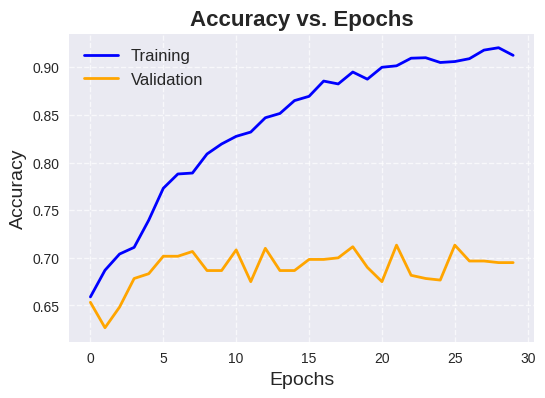

<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


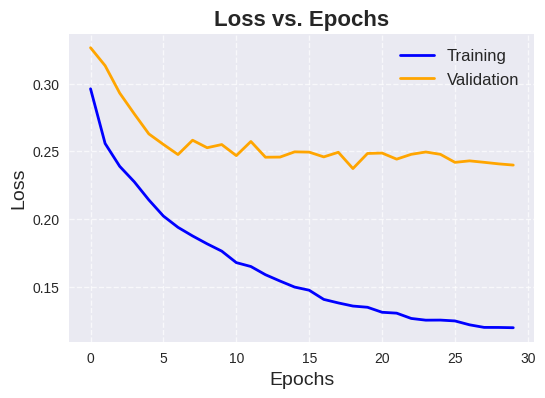

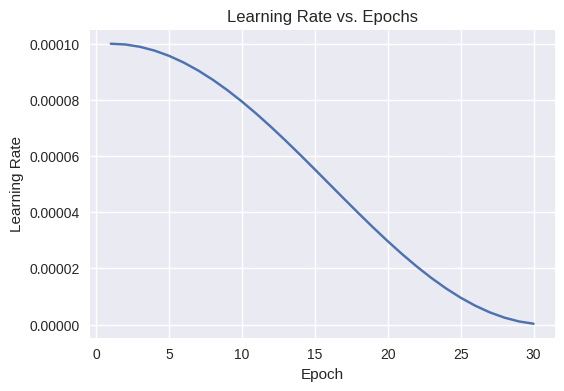

Epoch 31/120, Learning Rate: 0.0001


Epoch 31/120: 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


Train Loss: 0.1608, Accuracy: 0.8235, Precision: 0.8177, Recall: 0.8235, F1 Score: 0.8154


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Validation Inference Time: 2.16 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2529, Accuracy: 0.6417, Precision: 0.6998, Recall: 0.6417, F1 Score: 0.6561
Epoch 32/120, Learning Rate: 9.984588209998774e-05


Epoch 32/120: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Train Loss: 0.1318, Accuracy: 0.8885, Precision: 0.8865, Recall: 0.8885, F1 Score: 0.8851


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Validation Inference Time: 2.13 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2249, Accuracy: 0.7217, Precision: 0.7254, Recall: 0.7217, F1 Score: 0.7230
Best model updated based on validation accuracy
Epoch 33/120, Learning Rate: 9.938447858805392e-05


Epoch 33/120: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


Train Loss: 0.1226, Accuracy: 0.9070, Precision: 0.9058, Recall: 0.9070, F1 Score: 0.9043


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Validation Inference Time: 2.24 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2424, Accuracy: 0.6867, Precision: 0.7150, Recall: 0.6867, F1 Score: 0.6958
Epoch 34/120, Learning Rate: 9.861863417028185e-05


Epoch 34/120: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


Train Loss: 0.1178, Accuracy: 0.9110, Precision: 0.9096, Recall: 0.9110, F1 Score: 0.9087


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Validation Inference Time: 2.14 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2478, Accuracy: 0.6933, Precision: 0.7038, Recall: 0.6933, F1 Score: 0.6958
Epoch 35/120, Learning Rate: 9.755307053217622e-05


Epoch 35/120: 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]


Train Loss: 0.1152, Accuracy: 0.9140, Precision: 0.9126, Recall: 0.9140, F1 Score: 0.9122


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Validation Inference Time: 1.99 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2571, Accuracy: 0.6817, Precision: 0.6991, Recall: 0.6817, F1 Score: 0.6812
Epoch 36/120, Learning Rate: 9.619435722790178e-05


Epoch 36/120: 100%|██████████| 16/16 [00:07<00:00,  2.16it/s]


Train Loss: 0.1121, Accuracy: 0.9225, Precision: 0.9216, Recall: 0.9225, F1 Score: 0.9207


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


Validation Inference Time: 1.92 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2473, Accuracy: 0.6983, Precision: 0.7091, Recall: 0.6983, F1 Score: 0.7016
Epoch 37/120, Learning Rate: 9.455087117679744e-05


Epoch 37/120: 100%|██████████| 16/16 [00:07<00:00,  2.14it/s]


Train Loss: 0.1097, Accuracy: 0.9235, Precision: 0.9221, Recall: 0.9235, F1 Score: 0.9218


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Validation Inference Time: 2.25 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2585, Accuracy: 0.6783, Precision: 0.6989, Recall: 0.6783, F1 Score: 0.6825
Epoch 38/120, Learning Rate: 9.263274501688284e-05


Epoch 38/120: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


Train Loss: 0.1075, Accuracy: 0.9270, Precision: 0.9259, Recall: 0.9270, F1 Score: 0.9258


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


Validation Inference Time: 2.05 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2626, Accuracy: 0.6750, Precision: 0.7093, Recall: 0.6750, F1 Score: 0.6817
Epoch 39/120, Learning Rate: 9.04518046337755e-05


Epoch 39/120: 100%|██████████| 16/16 [00:08<00:00,  2.00it/s]


Train Loss: 0.1028, Accuracy: 0.9410, Precision: 0.9404, Recall: 0.9410, F1 Score: 0.9402


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Validation Inference Time: 2.18 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2398, Accuracy: 0.6867, Precision: 0.7111, Recall: 0.6867, F1 Score: 0.6935
Epoch 40/120, Learning Rate: 8.802149625017354e-05


Epoch 40/120: 100%|██████████| 16/16 [00:07<00:00,  2.00it/s]


Train Loss: 0.0988, Accuracy: 0.9435, Precision: 0.9429, Recall: 0.9435, F1 Score: 0.9428


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Validation Inference Time: 2.23 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2382, Accuracy: 0.7117, Precision: 0.7283, Recall: 0.7117, F1 Score: 0.7184
Epoch 41/120, Learning Rate: 8.535680352542143e-05


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]/s]


Validation Inference Time: 2.06 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2520, Accuracy: 0.6933, Precision: 0.7053, Recall: 0.6933, F1 Score: 0.6944
Epoch 42/120, Learning Rate: 8.247415517626753e-05


Epoch 42/120: 100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


Train Loss: 0.0949, Accuracy: 0.9490, Precision: 0.9486, Recall: 0.9490, F1 Score: 0.9485


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Validation Inference Time: 2.00 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2448, Accuracy: 0.6850, Precision: 0.7097, Recall: 0.6850, F1 Score: 0.6934
Epoch 43/120, Learning Rate: 7.939132368836218e-05


Epoch 43/120: 100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


Train Loss: 0.0915, Accuracy: 0.9595, Precision: 0.9592, Recall: 0.9595, F1 Score: 0.9591


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


Validation Inference Time: 2.05 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2659, Accuracy: 0.6633, Precision: 0.6947, Recall: 0.6633, F1 Score: 0.6679
Epoch 44/120, Learning Rate: 7.612731574297384e-05


Epoch 44/120: 100%|██████████| 16/16 [00:07<00:00,  2.05it/s]


Train Loss: 0.0904, Accuracy: 0.9605, Precision: 0.9602, Recall: 0.9605, F1 Score: 0.9601


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


Validation Inference Time: 2.07 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2443, Accuracy: 0.6867, Precision: 0.7095, Recall: 0.6867, F1 Score: 0.6928
Epoch 45/120, Learning Rate: 7.270225503447863e-05


Epoch 45/120: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


Train Loss: 0.0875, Accuracy: 0.9615, Precision: 0.9612, Recall: 0.9615, F1 Score: 0.9611


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Validation Inference Time: 2.17 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2415, Accuracy: 0.6867, Precision: 0.7088, Recall: 0.6867, F1 Score: 0.6944
Epoch 46/120, Learning Rate: 6.913725820109265e-05


Epoch 46/120: 100%|██████████| 16/16 [00:07<00:00,  2.05it/s]


Train Loss: 0.0850, Accuracy: 0.9750, Precision: 0.9750, Recall: 0.9750, F1 Score: 0.9748


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Validation Inference Time: 2.16 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2478, Accuracy: 0.6933, Precision: 0.7062, Recall: 0.6933, F1 Score: 0.6965
Epoch 47/120, Learning Rate: 6.54543046337755e-05


Epoch 47/120: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s]


Train Loss: 0.0831, Accuracy: 0.9775, Precision: 0.9774, Recall: 0.9775, F1 Score: 0.9774


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Validation Inference Time: 1.99 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2417, Accuracy: 0.7133, Precision: 0.7222, Recall: 0.7133, F1 Score: 0.7168
Epoch 48/120, Learning Rate: 6.167610096597599e-05


Epoch 48/120: 100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


Train Loss: 0.0823, Accuracy: 0.9730, Precision: 0.9730, Recall: 0.9730, F1 Score: 0.9727


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Validation Inference Time: 2.03 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2481, Accuracy: 0.6867, Precision: 0.7106, Recall: 0.6867, F1 Score: 0.6925
Epoch 49/120, Learning Rate: 5.782594107968634e-05


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]/s]


Validation Inference Time: 1.98 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2510, Accuracy: 0.6900, Precision: 0.7046, Recall: 0.6900, F1 Score: 0.6918
Epoch 50/120, Learning Rate: 5.392756249091361e-05


Epoch 50/120: 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]


Train Loss: 0.0792, Accuracy: 0.9760, Precision: 0.9760, Recall: 0.9760, F1 Score: 0.9758


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Validation Inference Time: 2.15 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2585, Accuracy: 0.6800, Precision: 0.7032, Recall: 0.6800, F1 Score: 0.6863
Epoch 51/120, Learning Rate: 5.0005e-05


Epoch 51/120: 100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


Train Loss: 0.0763, Accuracy: 0.9820, Precision: 0.9820, Recall: 0.9820, F1 Score: 0.9819


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Validation Inference Time: 2.16 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2487, Accuracy: 0.6900, Precision: 0.7151, Recall: 0.6900, F1 Score: 0.6989
Epoch 52/120, Learning Rate: 4.60824375090864e-05


Epoch 52/120: 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]


Train Loss: 0.0760, Accuracy: 0.9840, Precision: 0.9839, Recall: 0.9840, F1 Score: 0.9839


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Validation Inference Time: 2.13 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2559, Accuracy: 0.6717, Precision: 0.6991, Recall: 0.6717, F1 Score: 0.6773
Epoch 53/120, Learning Rate: 4.218405892031367e-05


Epoch 53/120: 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]


Train Loss: 0.0741, Accuracy: 0.9860, Precision: 0.9860, Recall: 0.9860, F1 Score: 0.9859


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Validation Inference Time: 2.26 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2449, Accuracy: 0.6817, Precision: 0.7132, Recall: 0.6817, F1 Score: 0.6918
Epoch 54/120, Learning Rate: 3.833389903402401e-05


Epoch 54/120: 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]


Train Loss: 0.0721, Accuracy: 0.9900, Precision: 0.9900, Recall: 0.9900, F1 Score: 0.9900


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


Validation Inference Time: 2.05 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2513, Accuracy: 0.6950, Precision: 0.7017, Recall: 0.6950, F1 Score: 0.6941
Epoch 55/120, Learning Rate: 3.4555695366224505e-05


Epoch 55/120: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


Train Loss: 0.0706, Accuracy: 0.9895, Precision: 0.9895, Recall: 0.9895, F1 Score: 0.9894


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Validation Inference Time: 2.23 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2485, Accuracy: 0.6750, Precision: 0.7035, Recall: 0.6750, F1 Score: 0.6835
Epoch 56/120, Learning Rate: 3.087274179890734e-05


Epoch 56/120: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Train Loss: 0.0697, Accuracy: 0.9895, Precision: 0.9895, Recall: 0.9895, F1 Score: 0.9895


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Validation Inference Time: 2.49 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2437, Accuracy: 0.6850, Precision: 0.7012, Recall: 0.6850, F1 Score: 0.6887
Epoch 57/120, Learning Rate: 2.730774496552136e-05


Epoch 57/120: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Train Loss: 0.0686, Accuracy: 0.9885, Precision: 0.9885, Recall: 0.9885, F1 Score: 0.9884


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Validation Inference Time: 2.34 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2494, Accuracy: 0.6800, Precision: 0.6942, Recall: 0.6800, F1 Score: 0.6829
Epoch 58/120, Learning Rate: 2.388268425702614e-05


Epoch 58/120: 100%|██████████| 16/16 [00:08<00:00,  1.91it/s]


Train Loss: 0.0668, Accuracy: 0.9955, Precision: 0.9955, Recall: 0.9955, F1 Score: 0.9955


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Validation Inference Time: 2.20 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2421, Accuracy: 0.6883, Precision: 0.7066, Recall: 0.6883, F1 Score: 0.6940
Epoch 59/120, Learning Rate: 2.061867631163781e-05


Epoch 59/120: 100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


Train Loss: 0.0667, Accuracy: 0.9905, Precision: 0.9905, Recall: 0.9905, F1 Score: 0.9905


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Validation Inference Time: 2.27 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2468, Accuracy: 0.6750, Precision: 0.6899, Recall: 0.6750, F1 Score: 0.6771
Epoch 60/120, Learning Rate: 1.7535844823732476e-05


Epoch 60/120: 100%|██████████| 16/16 [00:08<00:00,  1.99it/s]


Train Loss: 0.0653, Accuracy: 0.9950, Precision: 0.9950, Recall: 0.9950, F1 Score: 0.9950


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Validation Inference Time: 2.10 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2458, Accuracy: 0.6817, Precision: 0.7029, Recall: 0.6817, F1 Score: 0.6869
Epoch 61/120, Learning Rate: 1.465319647457856e-05


Epoch 61/120: 100%|██████████| 16/16 [00:07<00:00,  2.00it/s]


Train Loss: 0.0646, Accuracy: 0.9920, Precision: 0.9920, Recall: 0.9920, F1 Score: 0.9920


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Validation Inference Time: 2.24 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2371, Accuracy: 0.6967, Precision: 0.7089, Recall: 0.6967, F1 Score: 0.7005
Epoch 62/120, Learning Rate: 1.1988503749826454e-05


Epoch 62/120: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


Train Loss: 0.0636, Accuracy: 0.9920, Precision: 0.9920, Recall: 0.9920, F1 Score: 0.9920


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Validation Inference Time: 2.09 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2420, Accuracy: 0.6867, Precision: 0.7071, Recall: 0.6867, F1 Score: 0.6924
Epoch 63/120, Learning Rate: 9.558195366224508e-06


Epoch 63/120: 100%|██████████| 16/16 [00:08<00:00,  1.89it/s]


Train Loss: 0.0627, Accuracy: 0.9920, Precision: 0.9920, Recall: 0.9920, F1 Score: 0.9920


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Validation Inference Time: 2.13 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2428, Accuracy: 0.6750, Precision: 0.6986, Recall: 0.6750, F1 Score: 0.6805
Epoch 64/120, Learning Rate: 7.377254983117161e-06


Epoch 64/120: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Train Loss: 0.0616, Accuracy: 0.9935, Precision: 0.9935, Recall: 0.9935, F1 Score: 0.9935


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Validation Inference Time: 2.18 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2387, Accuracy: 0.6833, Precision: 0.7019, Recall: 0.6833, F1 Score: 0.6882
Epoch 65/120, Learning Rate: 5.459128823202552e-06


Epoch 65/120: 100%|██████████| 16/16 [00:08<00:00,  2.00it/s]


Train Loss: 0.0614, Accuracy: 0.9935, Precision: 0.9935, Recall: 0.9935, F1 Score: 0.9935


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Validation Inference Time: 2.23 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2378, Accuracy: 0.6833, Precision: 0.7019, Recall: 0.6833, F1 Score: 0.6878
Epoch 66/120, Learning Rate: 3.8156427720982195e-06


Epoch 66/120: 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


Train Loss: 0.0601, Accuracy: 0.9930, Precision: 0.9930, Recall: 0.9930, F1 Score: 0.9930


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Validation Inference Time: 2.12 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2351, Accuracy: 0.6850, Precision: 0.7028, Recall: 0.6850, F1 Score: 0.6899
Epoch 67/120, Learning Rate: 2.456929467823799e-06


Epoch 67/120: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s]


Train Loss: 0.0590, Accuracy: 0.9955, Precision: 0.9955, Recall: 0.9955, F1 Score: 0.9955


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Validation Inference Time: 2.20 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2332, Accuracy: 0.6900, Precision: 0.7066, Recall: 0.6900, F1 Score: 0.6942
Epoch 68/120, Learning Rate: 1.3913658297181604e-06


Epoch 68/120: 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


Train Loss: 0.0590, Accuracy: 0.9950, Precision: 0.9950, Recall: 0.9950, F1 Score: 0.9950


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Validation Inference Time: 2.20 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2312, Accuracy: 0.6867, Precision: 0.7030, Recall: 0.6867, F1 Score: 0.6907
Epoch 69/120, Learning Rate: 6.255214119460928e-07


Epoch 69/120: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


Train Loss: 0.0573, Accuracy: 0.9955, Precision: 0.9955, Recall: 0.9955, F1 Score: 0.9955


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Validation Inference Time: 2.28 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2296, Accuracy: 0.6867, Precision: 0.7030, Recall: 0.6867, F1 Score: 0.6907
Epoch 70/120, Learning Rate: 1.6411790001226747e-07


Epoch 70/120: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


Train Loss: 0.0564, Accuracy: 0.9965, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Validation Inference Time: 2.20 sec, Peak GPU Memory: 426.23 MB
Validation Loss: 0.2278, Accuracy: 0.6867, Precision: 0.7030, Recall: 0.6867, F1 Score: 0.6907
Snapshot 1 saved


Testing: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Test Inference Time: 2.18 sec, Peak GPU Memory: 428.99 MB
Test Loss: 0.1804, Accuracy: 0.7217, Precision: 0.7254, Recall: 0.7217, F1 Score: 0.7230
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.49      0.48      0.48       117
           1       0.82      0.80      0.81       393
           2       0.60      0.69      0.64        90

    accuracy                           0.72       600
   macro avg       0.64      0.66      0.65       600
weighted avg       0.73      0.72      0.72       600



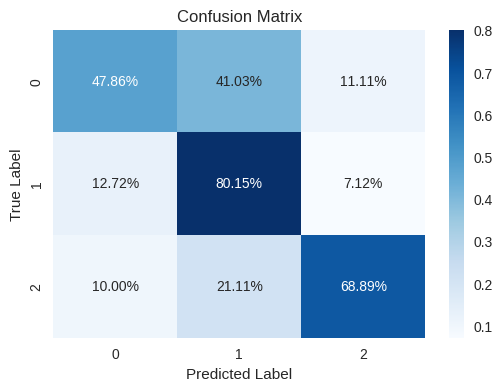

Test Sensitivity: 0.8630, Test Specificity: 0.5385


<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


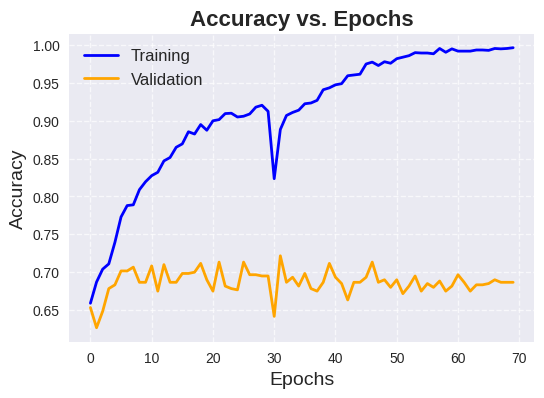

<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


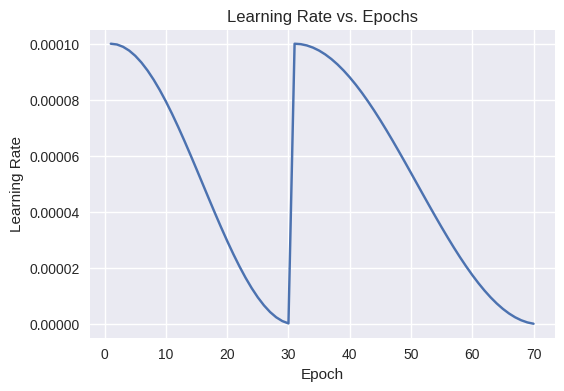

Epoch 71/120, Learning Rate: 0.0001


Epoch 71/120: 100%|██████████| 16/16 [00:08<00:00,  1.99it/s]


Train Loss: 0.1133, Accuracy: 0.8645, Precision: 0.8609, Recall: 0.8645, F1 Score: 0.8586


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Validation Inference Time: 2.25 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.1990, Accuracy: 0.6700, Precision: 0.7003, Recall: 0.6700, F1 Score: 0.6799
Epoch 72/120, Learning Rate: 9.990134628777144e-05


Epoch 72/120: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Train Loss: 0.0991, Accuracy: 0.8875, Precision: 0.8849, Recall: 0.8875, F1 Score: 0.8849


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Validation Inference Time: 2.09 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.1862, Accuracy: 0.7033, Precision: 0.6992, Recall: 0.7033, F1 Score: 0.6995
Epoch 73/120, Learning Rate: 9.960577449221733e-05


Epoch 73/120: 100%|██████████| 16/16 [00:08<00:00,  2.00it/s]


Train Loss: 0.0907, Accuracy: 0.9120, Precision: 0.9104, Recall: 0.9120, F1 Score: 0.9103


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Validation Inference Time: 2.14 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2036, Accuracy: 0.6783, Precision: 0.6977, Recall: 0.6783, F1 Score: 0.6796
Epoch 74/120, Learning Rate: 9.91144511001808e-05


Epoch 74/120: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


Train Loss: 0.0876, Accuracy: 0.9120, Precision: 0.9107, Recall: 0.9120, F1 Score: 0.9098


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Validation Inference Time: 2.25 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.1946, Accuracy: 0.6983, Precision: 0.7207, Recall: 0.6983, F1 Score: 0.7058
Epoch 75/120, Learning Rate: 9.84293151406259e-05


Epoch 75/120: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Train Loss: 0.0839, Accuracy: 0.9175, Precision: 0.9159, Recall: 0.9175, F1 Score: 0.9159


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Validation Inference Time: 2.33 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2075, Accuracy: 0.6817, Precision: 0.7043, Recall: 0.6817, F1 Score: 0.6878
Epoch 76/120, Learning Rate: 9.75530705321762e-05


Epoch 76/120: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


Train Loss: 0.0792, Accuracy: 0.9270, Precision: 0.9261, Recall: 0.9270, F1 Score: 0.9262


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Validation Inference Time: 2.22 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2054, Accuracy: 0.7100, Precision: 0.7005, Recall: 0.7100, F1 Score: 0.6951
Epoch 77/120, Learning Rate: 9.648917541198312e-05


Epoch 77/120: 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]


Train Loss: 0.0780, Accuracy: 0.9340, Precision: 0.9333, Recall: 0.9340, F1 Score: 0.9326


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Validation Inference Time: 2.03 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2217, Accuracy: 0.6300, Precision: 0.6927, Recall: 0.6300, F1 Score: 0.6469
Epoch 78/120, Learning Rate: 9.524182848803865e-05


Epoch 78/120: 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


Train Loss: 0.0751, Accuracy: 0.9355, Precision: 0.9347, Recall: 0.9355, F1 Score: 0.9346


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Validation Inference Time: 2.14 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2196, Accuracy: 0.6733, Precision: 0.7057, Recall: 0.6733, F1 Score: 0.6780
Epoch 79/120, Learning Rate: 9.381595246879295e-05


Epoch 79/120: 100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


Train Loss: 0.0690, Accuracy: 0.9550, Precision: 0.9547, Recall: 0.9550, F1 Score: 0.9544


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Validation Inference Time: 2.23 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2083, Accuracy: 0.6883, Precision: 0.7010, Recall: 0.6883, F1 Score: 0.6894
Epoch 80/120, Learning Rate: 9.221717463547324e-05


Epoch 80/120: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


Train Loss: 0.0663, Accuracy: 0.9540, Precision: 0.9538, Recall: 0.9540, F1 Score: 0.9534


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Validation Inference Time: 2.15 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2143, Accuracy: 0.6683, Precision: 0.6965, Recall: 0.6683, F1 Score: 0.6747
Epoch 81/120, Learning Rate: 9.04518046337755e-05


Epoch 81/120: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Train Loss: 0.0656, Accuracy: 0.9585, Precision: 0.9582, Recall: 0.9585, F1 Score: 0.9581


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Validation Inference Time: 2.27 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2023, Accuracy: 0.7100, Precision: 0.7044, Recall: 0.7100, F1 Score: 0.7039
Epoch 82/120, Learning Rate: 8.852680957257558e-05


Epoch 82/120: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


Train Loss: 0.0615, Accuracy: 0.9595, Precision: 0.9592, Recall: 0.9595, F1 Score: 0.9590


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


Validation Inference Time: 2.07 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2076, Accuracy: 0.6700, Precision: 0.7080, Recall: 0.6700, F1 Score: 0.6828
Epoch 83/120, Learning Rate: 8.644978652793345e-05


Epoch 83/120: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s]


Train Loss: 0.0619, Accuracy: 0.9575, Precision: 0.9573, Recall: 0.9575, F1 Score: 0.9574


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Validation Inference Time: 2.22 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.1990, Accuracy: 0.7100, Precision: 0.7059, Recall: 0.7100, F1 Score: 0.7078
Epoch 84/120, Learning Rate: 8.422893256090478e-05


Epoch 84/120: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


Train Loss: 0.0573, Accuracy: 0.9675, Precision: 0.9676, Recall: 0.9675, F1 Score: 0.9671


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


Validation Inference Time: 2.11 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.1973, Accuracy: 0.7117, Precision: 0.7049, Recall: 0.7117, F1 Score: 0.7057
Epoch 85/120, Learning Rate: 8.187301236748573e-05


Epoch 85/120: 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


Train Loss: 0.0544, Accuracy: 0.9775, Precision: 0.9774, Recall: 0.9775, F1 Score: 0.9774


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Validation Inference Time: 2.13 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.1958, Accuracy: 0.7083, Precision: 0.7081, Recall: 0.7083, F1 Score: 0.7082
Epoch 86/120, Learning Rate: 7.939132368836219e-05


Epoch 86/120: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


Train Loss: 0.0519, Accuracy: 0.9835, Precision: 0.9835, Recall: 0.9835, F1 Score: 0.9834


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Validation Inference Time: 2.18 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2056, Accuracy: 0.7017, Precision: 0.7117, Recall: 0.7017, F1 Score: 0.7055
Epoch 87/120, Learning Rate: 7.679366061497492e-05


Epoch 87/120: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


Train Loss: 0.0496, Accuracy: 0.9850, Precision: 0.9850, Recall: 0.9850, F1 Score: 0.9850


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Validation Inference Time: 2.17 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2094, Accuracy: 0.6750, Precision: 0.7037, Recall: 0.6750, F1 Score: 0.6834
Epoch 88/120, Learning Rate: 7.409027493671524e-05


Epoch 88/120: 100%|██████████| 16/16 [00:07<00:00,  2.00it/s]


Train Loss: 0.0494, Accuracy: 0.9810, Precision: 0.9809, Recall: 0.9810, F1 Score: 0.9809


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Validation Inference Time: 2.09 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2164, Accuracy: 0.6683, Precision: 0.6992, Recall: 0.6683, F1 Score: 0.6760
Epoch 89/120, Learning Rate: 7.12918356817958e-05


Epoch 89/120: 100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


Train Loss: 0.0465, Accuracy: 0.9860, Precision: 0.9860, Recall: 0.9860, F1 Score: 0.9860


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Validation Inference Time: 2.12 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2143, Accuracy: 0.6883, Precision: 0.7063, Recall: 0.6883, F1 Score: 0.6926
Epoch 90/120, Learning Rate: 6.840938701147047e-05


Epoch 90/120: 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


Train Loss: 0.0440, Accuracy: 0.9890, Precision: 0.9890, Recall: 0.9890, F1 Score: 0.9890


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Validation Inference Time: 2.19 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2158, Accuracy: 0.6783, Precision: 0.6872, Recall: 0.6783, F1 Score: 0.6798
Epoch 91/120, Learning Rate: 6.545430463377548e-05


Epoch 91/120: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Train Loss: 0.0433, Accuracy: 0.9855, Precision: 0.9855, Recall: 0.9855, F1 Score: 0.9854


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Validation Inference Time: 2.23 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2277, Accuracy: 0.6567, Precision: 0.7015, Recall: 0.6567, F1 Score: 0.6679
Epoch 92/120, Learning Rate: 6.243825090880689e-05


Epoch 92/120: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


Train Loss: 0.0407, Accuracy: 0.9915, Precision: 0.9915, Recall: 0.9915, F1 Score: 0.9915


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Validation Inference Time: 2.15 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2170, Accuracy: 0.6633, Precision: 0.7089, Recall: 0.6633, F1 Score: 0.6765
Epoch 93/120, Learning Rate: 5.93731288227133e-05


Epoch 93/120: 100%|██████████| 16/16 [00:08<00:00,  1.91it/s]


Train Loss: 0.0401, Accuracy: 0.9905, Precision: 0.9905, Recall: 0.9905, F1 Score: 0.9905


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


Validation Inference Time: 2.11 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2245, Accuracy: 0.6633, Precision: 0.7002, Recall: 0.6633, F1 Score: 0.6733
Epoch 94/120, Learning Rate: 5.6271035012047397e-05


Epoch 94/120: 100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


Train Loss: 0.0381, Accuracy: 0.9915, Precision: 0.9915, Recall: 0.9915, F1 Score: 0.9915


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Validation Inference Time: 2.13 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2138, Accuracy: 0.6933, Precision: 0.7126, Recall: 0.6933, F1 Score: 0.6979
Epoch 95/120, Learning Rate: 5.3144212023868024e-05


Epoch 95/120: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Train Loss: 0.0358, Accuracy: 0.9960, Precision: 0.9960, Recall: 0.9960, F1 Score: 0.9960


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


Validation Inference Time: 2.07 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2202, Accuracy: 0.6717, Precision: 0.7121, Recall: 0.6717, F1 Score: 0.6834
Epoch 96/120, Learning Rate: 5.0005e-05


Epoch 96/120: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


Train Loss: 0.0347, Accuracy: 0.9960, Precision: 0.9960, Recall: 0.9960, F1 Score: 0.9960


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Validation Inference Time: 2.16 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2071, Accuracy: 0.6783, Precision: 0.6994, Recall: 0.6783, F1 Score: 0.6841
Epoch 97/120, Learning Rate: 4.6865787976131975e-05


Epoch 97/120: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


Train Loss: 0.0335, Accuracy: 0.9965, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Validation Inference Time: 2.21 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2157, Accuracy: 0.6750, Precision: 0.7072, Recall: 0.6750, F1 Score: 0.6848
Epoch 98/120, Learning Rate: 4.373896498795261e-05


Epoch 98/120: 100%|██████████| 16/16 [00:08<00:00,  1.90it/s]


Train Loss: 0.0326, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Validation Inference Time: 2.18 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2141, Accuracy: 0.6883, Precision: 0.7067, Recall: 0.6883, F1 Score: 0.6929
Epoch 99/120, Learning Rate: 4.06368711772867e-05


Epoch 99/120: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


Train Loss: 0.0306, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


Validation Inference Time: 2.07 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2037, Accuracy: 0.6933, Precision: 0.7036, Recall: 0.6933, F1 Score: 0.6948
Epoch 100/120, Learning Rate: 3.7571749091193084e-05


Epoch 100/120: 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]


Train Loss: 0.0300, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


Validation Inference Time: 2.05 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2115, Accuracy: 0.6833, Precision: 0.6940, Recall: 0.6833, F1 Score: 0.6842
Epoch 101/120, Learning Rate: 3.4555695366224525e-05


Epoch 101/120: 100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


Train Loss: 0.0280, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


Validation Inference Time: 2.04 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2056, Accuracy: 0.7000, Precision: 0.7100, Recall: 0.7000, F1 Score: 0.7024
Epoch 102/120, Learning Rate: 3.160061298852955e-05


Epoch 102/120: 100%|██████████| 16/16 [00:07<00:00,  2.05it/s]


Train Loss: 0.0276, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Validation Inference Time: 2.32 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2078, Accuracy: 0.6867, Precision: 0.7016, Recall: 0.6867, F1 Score: 0.6903
Epoch 103/120, Learning Rate: 2.8718164318204197e-05


Epoch 103/120: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


Train Loss: 0.0264, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Validation Inference Time: 2.71 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2090, Accuracy: 0.6833, Precision: 0.6985, Recall: 0.6833, F1 Score: 0.6867
Epoch 104/120, Learning Rate: 2.5919725063284742e-05


Epoch 104/120: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


Train Loss: 0.0254, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Validation Inference Time: 2.24 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2100, Accuracy: 0.6850, Precision: 0.7074, Recall: 0.6850, F1 Score: 0.6915
Epoch 105/120, Learning Rate: 2.3216339385025057e-05


Epoch 105/120: 100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


Train Loss: 0.0239, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Validation Inference Time: 2.33 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2133, Accuracy: 0.6800, Precision: 0.6998, Recall: 0.6800, F1 Score: 0.6852
Epoch 106/120, Learning Rate: 2.0618676311637815e-05


Epoch 106/120: 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]


Train Loss: 0.0234, Accuracy: 0.9960, Precision: 0.9960, Recall: 0.9960, F1 Score: 0.9960


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Validation Inference Time: 2.10 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2054, Accuracy: 0.7033, Precision: 0.7028, Recall: 0.7033, F1 Score: 0.6991
Epoch 107/120, Learning Rate: 1.8136987632514258e-05


Epoch 107/120: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Train Loss: 0.0220, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Validation Inference Time: 2.02 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2044, Accuracy: 0.6917, Precision: 0.7050, Recall: 0.6917, F1 Score: 0.6955
Epoch 108/120, Learning Rate: 1.578106743909521e-05


Epoch 108/120: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Train Loss: 0.0202, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Validation Inference Time: 2.41 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2098, Accuracy: 0.6717, Precision: 0.6953, Recall: 0.6717, F1 Score: 0.6789
Epoch 109/120, Learning Rate: 1.356021347206654e-05


Epoch 109/120: 100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


Train Loss: 0.0197, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Validation Inference Time: 2.25 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2090, Accuracy: 0.6767, Precision: 0.6949, Recall: 0.6767, F1 Score: 0.6819
Epoch 110/120, Learning Rate: 1.148319042742442e-05


Epoch 110/120: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


Train Loss: 0.0182, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Validation Inference Time: 2.26 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2126, Accuracy: 0.6783, Precision: 0.7002, Recall: 0.6783, F1 Score: 0.6840
Epoch 111/120, Learning Rate: 9.558195366224506e-06


Epoch 111/120: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


Train Loss: 0.0170, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Validation Inference Time: 2.35 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2091, Accuracy: 0.6767, Precision: 0.6944, Recall: 0.6767, F1 Score: 0.6816
Epoch 112/120, Learning Rate: 7.792825364526766e-06


Epoch 112/120: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


Train Loss: 0.0158, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Validation Inference Time: 2.13 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2061, Accuracy: 0.6933, Precision: 0.7036, Recall: 0.6933, F1 Score: 0.6948
Epoch 113/120, Learning Rate: 6.1940475312070395e-06


Epoch 113/120: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


Train Loss: 0.0146, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Validation Inference Time: 2.16 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2111, Accuracy: 0.6800, Precision: 0.6954, Recall: 0.6800, F1 Score: 0.6835
Epoch 114/120, Learning Rate: 4.768171511961362e-06


Epoch 114/120: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


Train Loss: 0.0139, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Validation Inference Time: 2.25 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2047, Accuracy: 0.6883, Precision: 0.7015, Recall: 0.6883, F1 Score: 0.6917
Epoch 115/120, Learning Rate: 3.5208245880168734e-06


Epoch 115/120: 100%|██████████| 16/16 [00:08<00:00,  1.99it/s]


Train Loss: 0.0124, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Validation Inference Time: 2.15 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2079, Accuracy: 0.6867, Precision: 0.7009, Recall: 0.6867, F1 Score: 0.6899
Epoch 116/120, Learning Rate: 2.456929467823799e-06


Epoch 116/120: 100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


Train Loss: 0.0114, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


Validation Inference Time: 2.05 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2082, Accuracy: 0.6850, Precision: 0.6994, Recall: 0.6850, F1 Score: 0.6884
Epoch 117/120, Learning Rate: 1.5806848593740944e-06


Epoch 117/120: 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]


Train Loss: 0.0107, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Validation Inference Time: 2.00 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2072, Accuracy: 0.6883, Precision: 0.7015, Recall: 0.6883, F1 Score: 0.6913
Epoch 118/120, Learning Rate: 8.955488998192071e-07


Epoch 118/120: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


Train Loss: 0.0093, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


Validation Inference Time: 2.03 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2064, Accuracy: 0.6850, Precision: 0.6970, Recall: 0.6850, F1 Score: 0.6876
Epoch 119/120, Learning Rate: 4.0422550778268403e-07


Epoch 119/120: 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]


Train Loss: 0.0082, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


Validation Inference Time: 2.05 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2057, Accuracy: 0.6850, Precision: 0.6970, Recall: 0.6850, F1 Score: 0.6876
Epoch 120/120, Learning Rate: 1.0865371222856339e-07


Epoch 120/120: 100%|██████████| 16/16 [00:07<00:00,  2.00it/s]


Train Loss: 0.0071, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Validation Inference Time: 2.09 sec, Peak GPU Memory: 428.99 MB
Validation Loss: 0.2050, Accuracy: 0.6850, Precision: 0.6970, Recall: 0.6850, F1 Score: 0.6876
Snapshot 2 saved


Testing: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


Test Inference Time: 2.06 sec, Peak GPU Memory: 431.76 MB
Test Loss: 0.1339, Accuracy: 0.7217, Precision: 0.7254, Recall: 0.7217, F1 Score: 0.7230
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.49      0.48      0.48       117
           1       0.82      0.80      0.81       393
           2       0.60      0.69      0.64        90

    accuracy                           0.72       600
   macro avg       0.64      0.66      0.65       600
weighted avg       0.73      0.72      0.72       600



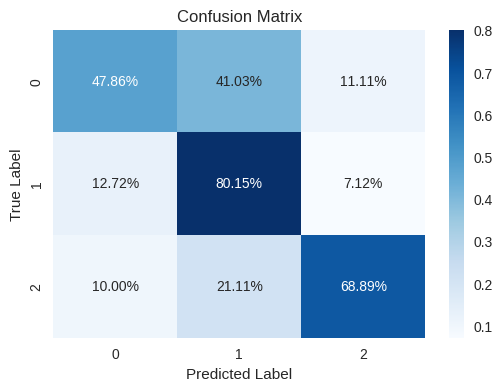

Test Sensitivity: 0.8630, Test Specificity: 0.5385


<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


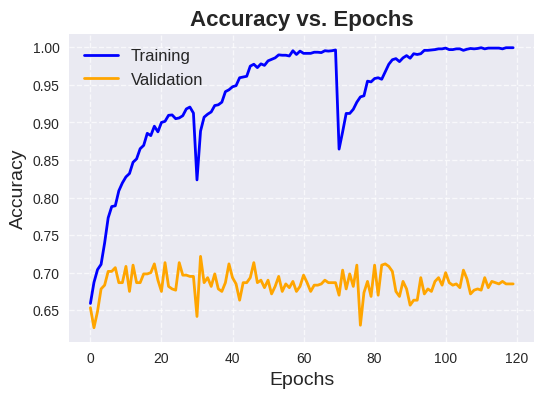

<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


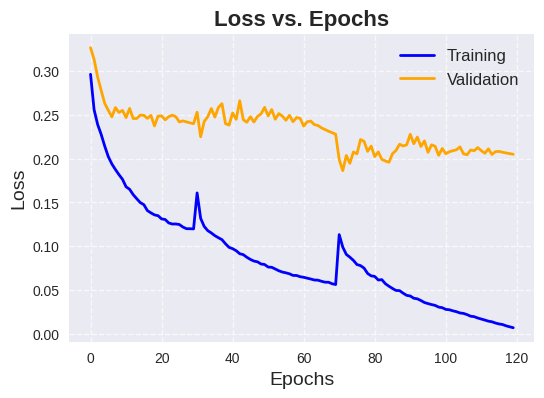

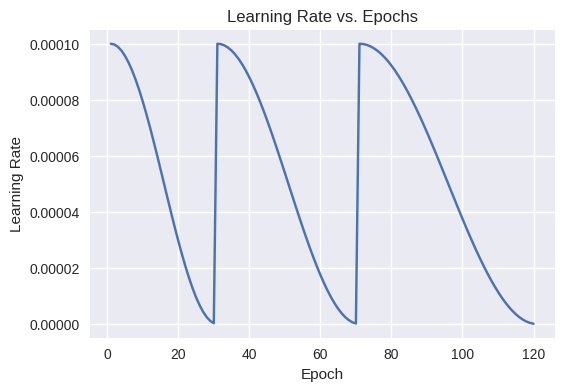

In [15]:
ensemble_models = snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device)